In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

try:
    import gseapy as gp
    GSEAPY_OK = True
except Exception as e:
    print("gseapy not available:", e)
    GSEAPY_OK = False

try:
    from mygene import MyGeneInfo
    MYGENE_OK = True
except Exception as e:
    print("mygene not available:", e)
    MYGENE_OK = False

print("gseapy:", GSEAPY_OK, "| mygene:", MYGENE_OK)


gseapy: True | mygene: True


In [2]:
genes = [
    "MKI67","CCNB1","CCNB2","CDK1","BIRC5","TOP2A","PCNA","PLK1","CDC20","AURKA",
    "AURKB","KIF11","KIF2C","KIF20A","CHEK1","CHEK2","TYMS","CENPF","CENPA","UBE2C"
]
len(genes), genes[:5]

(20, ['MKI67', 'CCNB1', 'CCNB2', 'CDK1', 'BIRC5'])

In [3]:
if MYGENE_OK:
    mg = MyGeneInfo()
    q = mg.querymany(genes, scopes='symbol', fields='symbol,name,entrezgene,ensembl.gene', species='human')
    df_check = pd.DataFrame(q)
    display(df_check[['query','symbol','name','entrezgene']].head(10))
else:
    print("mygene not installed — skipping symbol validation.")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


,query,symbol,name,entrezgene
0,MKI67,MKI67,marker of proliferation Ki-67,4288
1,CCNB1,CCNB1,cyclin B1,891
2,CCNB2,CCNB2,cyclin B2,9133
3,CDK1,CDK1,cyclin dependent kinase 1,983
4,BIRC5,BIRC5,baculoviral IAP repeat containing 5,332
5,TOP2A,TOP2A,DNA topoisomerase II alpha,7153
6,PCNA,PCNA,proliferating cell nuclear antigen,5111
7,PLK1,PLK1,polo like kinase 1,5347
8,CDC20,CDC20,cell division cycle 20,991
9,AURKA,AURKA,aurora kinase A,6790


In [6]:
# 1)  see what version and the function signature
import gseapy as gp, inspect
print("gseapy version:", gp.__version__)
print("enrichr signature:", inspect.signature(gp.enrichr))

# 2) pick libraries (you can list available ones with: gp.get_library_name())
gene_sets = [
    'KEGG_2021_Human',
    'Reactome_2022',
    'GO_Biological_Process_2021',
]

outdir = 'enrichr_out'
os.makedirs(outdir, exist_ok=True)

# 3) call enrichr WITHOUT 'description=' (some versions don't support it)
enr = gp.enrichr(
    gene_list=genes,
    gene_sets=gene_sets,
    outdir=outdir,
    cutoff=0.05  # adjusted p-value threshold
)

# 4) be robust to result attribute name differences across versions
res = getattr(enr, 'results', None)
if res is None:
    res = getattr(enr, 'res2d', None)  # older gseapy uses 'res2d'

if res is None or len(res) == 0:
    print("No results (or API/library name mismatch). Try different libraries or a larger gene list.")
else:
    display(res.head())


gseapy version: 1.1.9
enrichr signature: (gene_list: Iterable[str], gene_sets: Union[List[str], str, Dict[str, str]], organism: str = 'human', outdir: Optional[str] = None, background: Union[List[str], int, str] = None, cutoff: float = 0.05, format: str = 'pdf', figsize: Tuple[float, float] = (6.5, 6), top_term: int = 10, no_plot: bool = False, verbose: bool = False) -> gseapy.enrichr.Enrichr


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell cycle,8/124,2.054851e-13,4.931642e-12,0,0,114.160920,3335.028939,CDC20;CCNB2;CCNB1;PCNA;CHEK2;PLK1;CHEK1;CDK1
1,KEGG_2021_Human,Oocyte meiosis,6/129,2.304737e-09,2.765684e-08,0,0,69.188153,1376.034698,CDC20;CCNB2;CCNB1;PLK1;CDK1;AURKA
2,KEGG_2021_Human,p53 signaling pathway,5/73,8.371753e-09,6.697402e-08,0,0,97.607843,1815.349961,CCNB2;CCNB1;CHEK2;CHEK1;CDK1
3,KEGG_2021_Human,Progesterone-mediated oocyte maturation,5/100,4.125949e-08,2.475569e-07,0,0,69.771930,1186.358967,CCNB2;CCNB1;PLK1;CDK1;AURKA
4,KEGG_2021_Human,Cellular senescence,5/156,3.818484e-07,1.832872e-06,0,0,43.772627,646.882479,CCNB2;CCNB1;CHEK2;CHEK1;CDK1


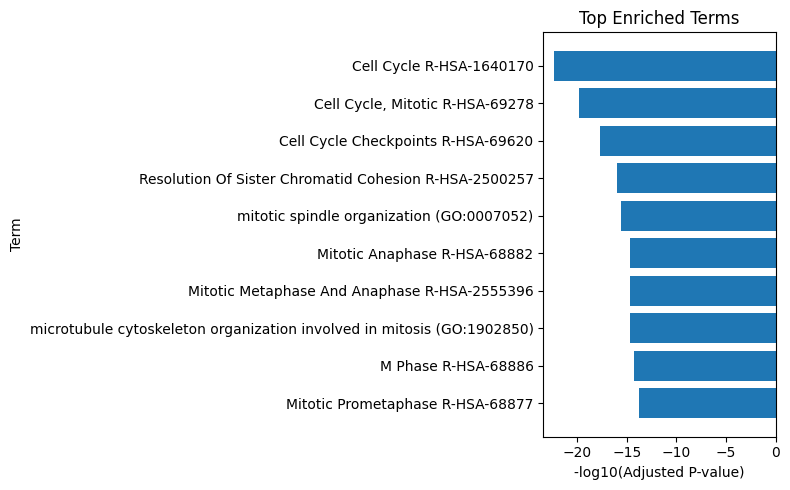

In [7]:
if res is None or len(res)==0:
    print("No significant terms found at the chosen cutoff. Try increasing cutoff or changing libraries.")
else:
    # Sort by adjusted p-value
    res_sorted = res.sort_values(by=['Adjusted P-value','P-value'], ascending=[True, True]).head(10).copy()
    res_sorted['-log10(AdjP)'] = -res_sorted['Adjusted P-value'].apply(lambda x: (0 if x<=0 else __import__('math').log10(x)))
    # The above creates negative values; flip sign for plotting clarity
    res_sorted['poslog10'] = res_sorted['-log10(AdjP)'] * -1
    
    plt.figure(figsize=(8,5))
    plt.barh(res_sorted['Term'], res_sorted['poslog10'])
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('Term')
    plt.title('Top Enriched Terms')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [8]:
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = os.path.join(outdir, f'enrichr_results_{ts}.csv')
if res is not None:
    res.to_csv(csv_path, index=False)
    print('Saved:', csv_path)
else:
    print('No results to save.')

Saved: enrichr_out\enrichr_results_20250815_114417.csv


In [9]:
if res is not None and len(res):
    top = res.sort_values(by=['Adjusted P-value','P-value']).head(5)
    summary_lines = [
        f"Analyzed {len(genes)} genes. Top enriched terms (adj p-value):"
    ]
    for _, row in top.iterrows():
        summary_lines.append(f" - {row['Term']} (AdjP={row['Adjusted P-value']:.2e})")
    print("\n".join(summary_lines))
else:
    print("No significant enrichment to summarize.")

Analyzed 20 genes. Top enriched terms (adj p-value):
 - Cell Cycle R-HSA-1640170 (AdjP=5.11e-23)
 - Cell Cycle, Mitotic R-HSA-69278 (AdjP=1.65e-20)
 - Cell Cycle Checkpoints R-HSA-69620 (AdjP=1.82e-18)
 - Resolution Of Sister Chromatid Cohesion R-HSA-2500257 (AdjP=9.85e-17)
 - mitotic spindle organization (GO:0007052) (AdjP=2.63e-16)
